In [1]:
from time import time
import numpy as np
numSeed = 42
np.random.seed(numSeed)
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Lambda, Conv2D, Conv2DTranspose, Activation, Flatten, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))

import sys  
sys.path.append('../')
from loadFrey import *
from util import importNotebook
from util.dataProcess import *
from util.util import plotScatterDecode, plotProgress, plotCompDecode, plotScatterEncode, addNoise

c:\users\user\anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


importing Jupyter notebook from ..\util\dataProcess.ipynb


## Declare the parameters

In [24]:
numEpochs = 100
sizeBatch = 16
sizeKernel = 3
dimInter = 128
dimEncode = 32
layer_filters = [8, 32]
stdEps = 1.0 
ratRecon = 0.9999
factNoise = 0
nameOptim = 'adam'
patience = 3
pathSave = '../models/temp/'

## Load the datasets

In [25]:
data = load_frey_face_images('frey_rawface.mat')
xTrain, xTest, __ = splitData(data, ratio=[1, 0])
xTrain = xTrain.astype('float32') / 255.
xTest = xTrain
numTrain = len(xTrain)
numTest = len(xTest)
dimInput = [*xTrain.shape[1:], 1]  # adapt 28*20 as 28*20*1

xTrain = np.reshape(xTrain, [-1, *dimInput])
xTest = np.reshape(xTest, [-1, *dimInput])
print(xTrain.shape)
print(xTest.shape)


(1965, 28, 20, 1)
(1965, 28, 20, 1)


## Construct the encoder and decoder

In [26]:
inputs = Input(shape=(dimInput))  # adapt this if using `channels_first` image data format
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=sizeKernel,
               strides=2,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
x = Dense(dimInter, activation='relu')(x)
zMean = Dense(dimEncode)(x)
zSigmaLog = Dense(dimEncode)(x) # log for linear dense

def sampling(args):
    zMean, zSigmaLog = args
    epsilon = K.random_normal(shape=(K.shape(zMean)[0], dimEncode),
                              mean=0., stddev=stdEps)
    return zMean + K.exp(zSigmaLog) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
# z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
z = Lambda(sampling)([zMean, zSigmaLog])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

# Build the Decoder Model
inputLatent = Input(shape=(dimEncode,), name='decoder_input')
x = Dense(dimInter, activation='relu')(inputLatent)
x = Dense(shape[1] * shape[2] * shape[3])(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=sizeKernel,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=sizeKernel,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(inputLatent, outputs, name='decoder')
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 20, 1)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 10, 8)    80          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 7, 5, 32)     2336        conv2d_6[0][0]                   
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 1120)         0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
dense_11 (

## Construct the autoencoder

In [27]:
# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 20, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 32)                154160    
_________________________________________________________________
decoder (Model)              (None, 28, 20, 1)         160337    
Total params: 314,497
Trainable params: 314,497
Non-trainable params: 0
_________________________________________________________________


## Compile and train

In [28]:
def lossVAE(zMean, zSigmaLog):
    def loss(tensorInput, tensorDecode):
        lossRecon =  metrics.binary_crossentropy(K.flatten(tensorInput), K.flatten(tensorDecode))
        lossKL = - 0.5 * K.sum(1 + 2 * zSigmaLog - K.square(zMean) - K.square(K.exp(zSigmaLog)), axis=-1)
#         lossKL = - 0.5 * K.mean(1 + zSigmaLog - K.square(zMean) - K.exp(zSigmaLog), axis=-1)
        return ratRecon * lossRecon + (1 - ratRecon) * lossKL
    return loss

autoencoder.compile(optimizer=nameOptim, loss=lossVAE(zMean, zSigmaLog))

# callback setting
es_cb = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
chkpt = pathSave + 'Conv_AutoEncoder_Frey.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# Train the autoencoder
tic = time()
history = autoencoder.fit(xTrain, xTrain,
                epochs=numEpochs,
                batch_size=sizeBatch,
                shuffle=True,
                callbacks=[es_cb, cp_cb],
                validation_data=(xTest, xTest))
timeTrain = time() - tic

Train on 1965 samples, validate on 1965 samples
Epoch 1/100
1888/1965 [===========================>..] - ETA: 0s - loss: 0.1387
Epoch 00001: val_loss improved from inf to 0.01920, saving model to ../models/temp/Conv_AutoEncoder_Frey.01-0.13-0.02.hdf5
1965/1965 [==============================] - 2s 1ms/step - loss: 0.1340 - val_loss: 0.0192
Epoch 2/100
1888/1965 [===========================>..] - ETA: 0s - loss: 0.0182
Epoch 00002: val_loss improved from 0.01920 to 0.01766, saving model to ../models/temp/Conv_AutoEncoder_Frey.02-0.02-0.02.hdf5
1965/1965 [==============================] - 1s 678us/step - loss: 0.0182 - val_loss: 0.0177
Epoch 3/100
1904/1965 [============================>.] - ETA: 0s - loss: 0.0176
Epoch 00003: val_loss improved from 0.01766 to 0.01743, saving model to ../models/temp/Conv_AutoEncoder_Frey.03-0.02-0.02.hdf5
1965/1965 [==============================] - 1s 640us/step - loss: 0.0176 - val_loss: 0.0174
Epoch 4/100
1904/1965 [============================>.] - E

## Show the historical training progress 

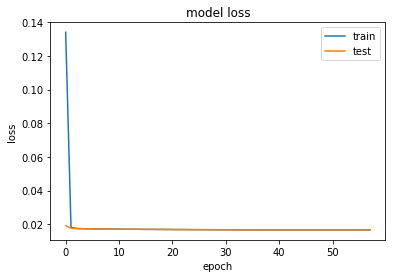

In [29]:
# print("traing consumed: " + str(timeTrain) + " seconds")
plotProgress(history)

## Get the encoding and decoding results of testing data, and get the mean/std of the encoding 

In [14]:
# encode and decode some digits
# note that we take them from the *test* set
encodeTest = encoder.predict(xTest)
decodeTest = decoder.predict(encodeTest)
meanEncTest = np.mean(encodeTest, axis=0)
stdEncTest = np.std(encodeTest, axis=0)

## Compare original digitals with the decoding results

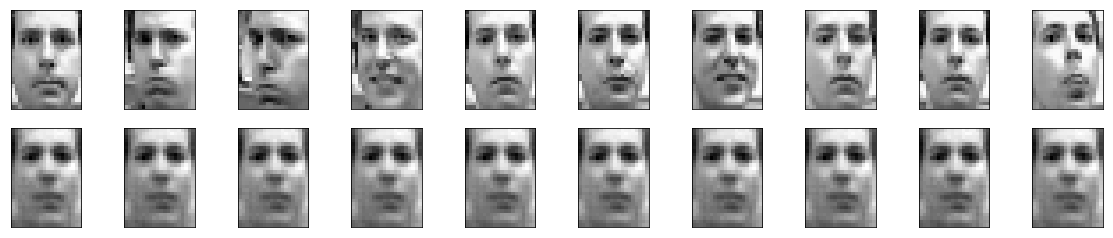

In [16]:
plotCompDecode(xTest, decodeTest, sizeDigit=[28, 20])

## Plot the scatter of the encoding space

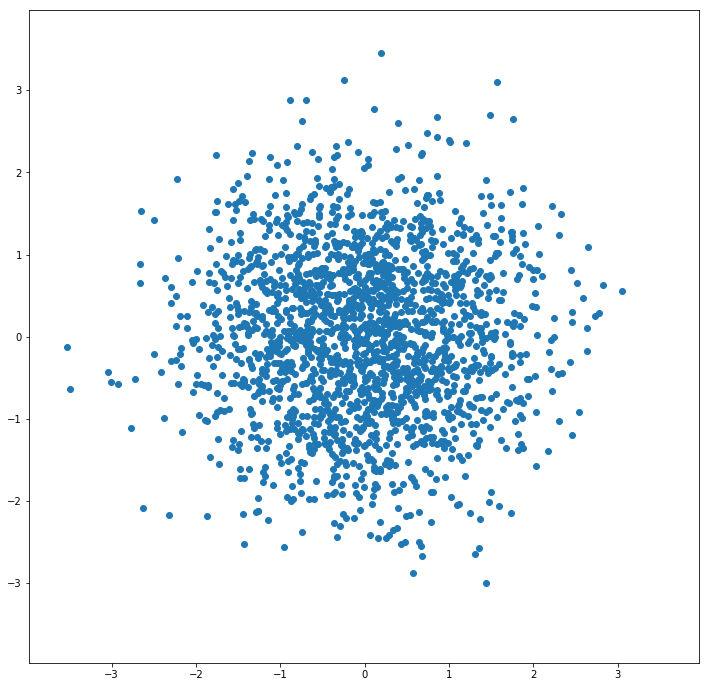

In [20]:
xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])

plotScatterEncode(encodeTest, y=None, xlim=xlim, ylim=ylim, numShow=10000)
# scoreSilh = silhouette_score(encodeTest, yTest)  

## Plot the decoding results from the encoding scatter 

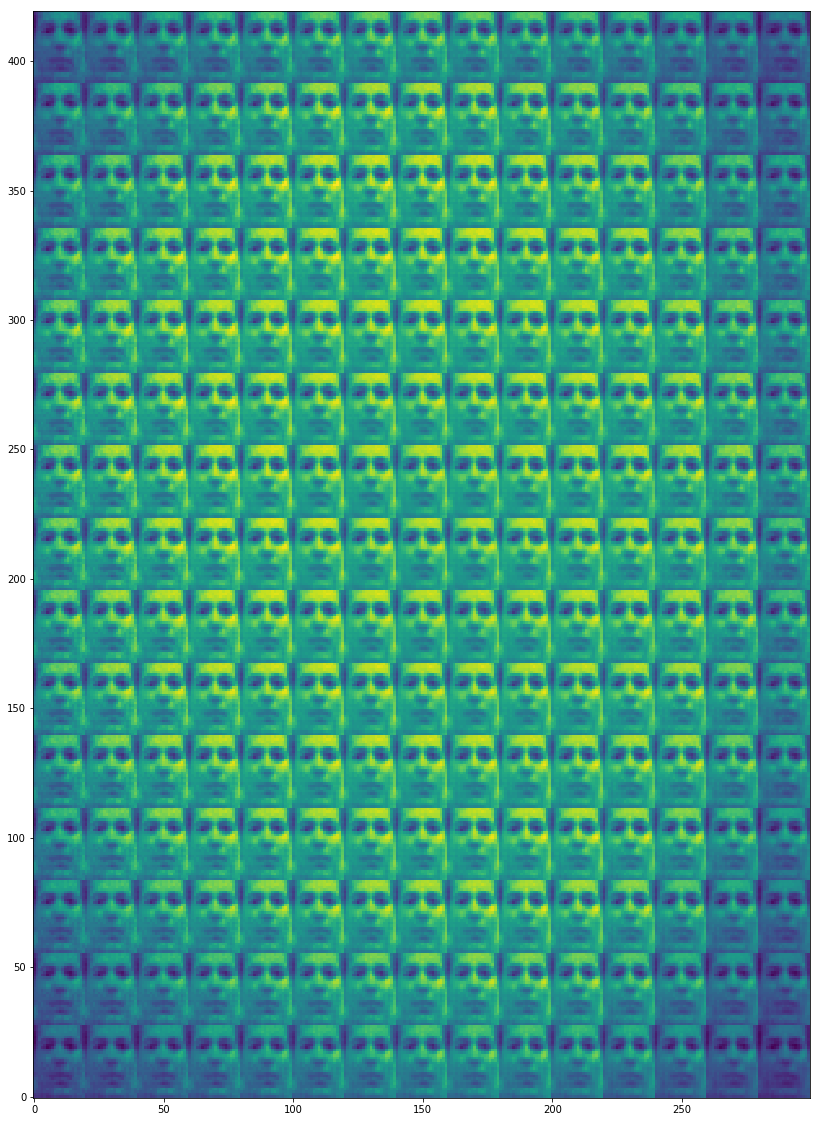

In [23]:
# display a 2D manifold of the digits
plotScatterDecode(decoder, sizeDigit=[28, 20], xlim=xlim, ylim=ylim)

In [ ]:
print(timeTrain, history.history["loss"][numEpochs-1], history.history["val_loss"][numEpochs-1], scoreSilh)

In [ ]:
(xTrain, _), (xTest, yTest) = mnist.load_data()